In [45]:
%pylab inline
from scipy.optimize import curve_fit
import pandas as pd
import pandas as pd
import seaborn as sns
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import matplotlib.style as style
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import sys
import bookie_package as bp
import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


In [46]:
df_both_seasons_away = pd.read_pickle('df_both_seasons_essentials')

## Add avg Away Team Goal Difference

In [47]:
df_both_seasons_away.head()

,Day,Month,Year,HomeTeam,AwayTeam,FTHG,FTAG,HST,AST,HTGDIFF,ATGDIFF
151,22,12,2019,Fortuna Dusseldorf,Union Berlin,NaN,NaN,NaN,NaN,NaN,NaN
152,22,12,2019,Paderborn,Ein Frankfurt,NaN,NaN,NaN,NaN,NaN,NaN
145,21,12,2019,Bayern Munich,Wolfsburg,NaN,NaN,NaN,NaN,NaN,NaN
146,21,12,2019,RB Leipzig,Augsburg,NaN,NaN,NaN,NaN,NaN,NaN
147,21,12,2019,Mainz,Leverkusen,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
d_both_seasons = bp.averages.avg_goal_diff(df_both_seasons_away, 'AVGATGDIFF', 'AwayTeam', 'A')

In [49]:
df_both_seasons = bp.averages.from_dict_value_to_df(d_both_seasons)

In [50]:
df_both_seasons=df_both_seasons.sort_values(['Year', 'Month','Day'], ascending=False)

In [51]:
avg_ftag_per_team=bp.averages.avg_goals(df_both_seasons, 'AVGFTAG', 'AwayTeam', 'A')

In [52]:
df_both_seasons = bp.averages.from_dict_value_to_df(avg_ftag_per_team)

In [53]:
df_both_seasons.to_excel('hansi.xlsx')

In [54]:
df_both_seasons=df_both_seasons.sort_values(['Year', 'Month','Day'], ascending=False)

## Add Columns with previous AST for each AwayTeam

In [55]:
team_with_past_AST=bp.averages.previous_data(df_both_seasons, 'AwayTeam', 'AST')

In [56]:
df_team_with_past_AST = bp.averages.from_dict_value_to_df(team_with_past_AST)

In [57]:
  df_team_with_past_AST = df_team_with_past_AST.reindex(columns=[ 'Day',
    'Month',
    'Year',
    'HomeTeam',
    'AwayTeam',
    'FTHG',
    'FTAG',
    'HTGDIFF',
    'ATGDIFF',
    'AVGATGDIFF',
    'AVGFTAG',
    'HST',
    'AST',
    'AST_1',
    'AST_2',
    'AST_3',
    'AST_4',
    'AST_5',
    'AST_6',
    'AST_7',
    'AST_8',
    'AST_9',
    'AST_10'
    ])

In [58]:
df_team_with_past_AST.sort_values(['Year', 'Month','Day'], ascending=False,inplace=True)

In [59]:
df_team_with_past_AST.fillna(0, inplace=True)

In [60]:
df_team_with_past_AST.to_excel('df_team_with_past_FTAG_away.xlsx')

In [61]:
df_result = df_team_with_past_AST.copy()

In [62]:
df_result = df_result.drop(['HomeTeam', 'AwayTeam'], axis = 1)

In [63]:
print('Shape of features:', df_result.shape)

Shape of features: (561, 21)


## Features and Labels and Convert Data to Arrays

In [64]:
# Labels are the values we want to predict
labels = np.array(df_result['FTAG'])

# Remove the labels from the features
# axis 1 refers to the columns
df_result= df_result.drop(['Day','AST_4','AST_5','AST_3', 'AST_7', 'AST_8','AST_6',  'AST_10', 'AST_9', 'Year','FTAG','FTHG', 'HTGDIFF', 'ATGDIFF', 'HST', 'AST'], axis = 1)

# Saving feature names for later use
feature_list = list(df_result.columns)

# Convert to numpy array
df_result = np.array(df_result)

## Training and Testing Sets

In [65]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    df_result, labels, test_size = 0.25,random_state = 42
)
                

In [66]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (420, 5)
Training Labels Shape: (420,)
Testing Features Shape: (141, 5)
Testing Labels Shape: (141,)


## Establish Baseline

In [67]:
# The baseline predictions are the historical averages
baseline_preds = train_features[:, feature_list.index('AVGFTAG')]
# AVerage goals made by home team

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - train_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'Goals.')

Average baseline error:  1.13 Goals.


## Train Model

In [68]:
rf = bp.prediction.random_forrest(train_features, train_labels, random_state = 42)

## Make Predictions on Test Data

In [69]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Goals.')

Mean Absolute Error: 1.02 Goals.


In [70]:
next_games=df_result
predictions_next_games = rf.predict(next_games)
next_games_predictions=np.round(predictions_next_games,0)

In [71]:
del df_both_seasons['FTHG']

In [72]:
df_both_seasons['FTAG'] = next_games_predictions
df_both_seasons

,Day,Month,Year,HomeTeam,AwayTeam,FTAG,HST,AST,HTGDIFF,ATGDIFF,AVGATGDIFF,AVGFTAG
151,22,12,2019,Fortuna Dusseldorf,Union Berlin,1.0,0.0,0.0,0.0,0.0,-0.4,0.9
152,22,12,2019,Paderborn,Ein Frankfurt,0.0,0.0,0.0,0.0,0.0,-0.1,1.1
145,21,12,2019,Bayern Munich,Wolfsburg,1.0,0.0,0.0,0.0,0.0,-0.4,1.1
146,21,12,2019,RB Leipzig,Augsburg,1.0,0.0,0.0,0.0,0.0,-0.9,0.9
147,21,12,2019,Mainz,Leverkusen,1.0,0.0,0.0,0.0,0.0,0.4,1.8
148,21,12,2019,Schalke 04,Freiburg,0.0,0.0,0.0,0.0,0.0,-0.6,1.0
149,21,12,2019,FC Koln,Werder Bremen,1.0,0.0,0.0,0.0,0.0,-0.6,1.4
150,21,12,2019,Hertha,M'gladbach,0.0,0.0,0.0,0.0,0.0,0.6,1.3
144,20,12,2019,Hoffenheim,Dortmund,1.0,0.0,0.0,0.0,0.0,-0.2,1.4
139,18,12,2019,Leverkusen,Hertha,2.0,7.0,5.0,-1.0,1.0,0.0,1.7


## Determine Performance Metrics

In [73]:
# Calculate mean absolute percentage error (MAPE)
err = errors/test_labels
err[np.isnan(err)] = 0
mape = err * 100
mape[mape == inf] = 0

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 60.55 %.


## Interpret Model Results

### Visualizing a Single Decision Tree

In [74]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree_away.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree_away.dot')
# Write graph to a png file
graph.write_png('tree_away.png')

In [75]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 21


In [76]:

# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 4, random_state=42)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree_away.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree_away.dot')

graph.write_png('small_tree_away.png');

### Variable Importances

In [77]:
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: AVGATGDIFF           Importance: 0.22837
Variable: Month                Importance: 0.21708
Variable: AST_2                Importance: 0.20572
Variable: AST_1                Importance: 0.19443
Variable: AVGFTAG              Importance: 0.15441


## Feature Reduction

In [78]:
sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk')

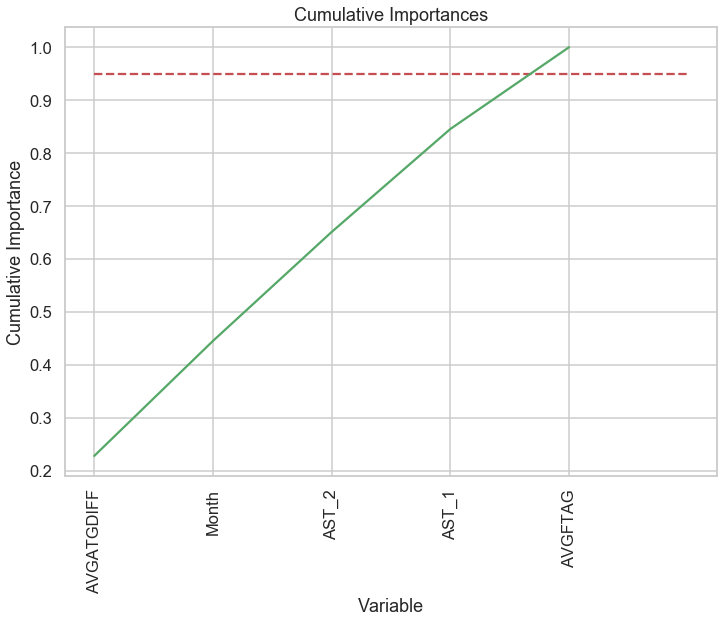

In [79]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(list(range(len(importances))), cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(list(range(len(importances))), sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

## Random Forest Optimization through Random Search

In [80]:
rs = bp.prediction.random_search(train_features,train_labels, cv=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished


In [81]:
best_params = rs.best_params_

In [82]:
best_params

{'n_estimators': 434,
 'min_samples_split': 10,
 'max_leaf_nodes': 19,
 'max_features': 0.6,
 'max_depth': 5,
 'bootstrap': False}

In [83]:
rf = bp.prediction.random_forrest(
    train_features, train_labels, 
    n_estimators=best_params['n_estimators'],
    random_state = 42,
    min_samples_split = best_params['min_samples_split'],
    max_leaf_nodes = best_params['max_leaf_nodes'],
    max_features = best_params['max_features'],
    max_depth = best_params['max_depth'],
    bootstrap = best_params['bootstrap']
)


In [84]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Goals.')

Mean Absolute Error: 0.97 Goals.


In [85]:
# Calculate mean absolute percentage error (MAPE)
err = errors/test_labels
err[np.isnan(err)] = 0
mape = err * 100
mape[mape == inf] = 0
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 64.38 %.


In [86]:
next_games=df_result
predictions_next_games = rf.predict(next_games)
next_games_predictions=np.round(predictions_next_games,0)

In [87]:
df_both_seasons['FTAG'] = next_games_predictions
df_both_seasons

,Day,Month,Year,HomeTeam,AwayTeam,FTAG,HST,AST,HTGDIFF,ATGDIFF,AVGATGDIFF,AVGFTAG
151,22,12,2019,Fortuna Dusseldorf,Union Berlin,1.0,0.0,0.0,0.0,0.0,-0.4,0.9
152,22,12,2019,Paderborn,Ein Frankfurt,1.0,0.0,0.0,0.0,0.0,-0.1,1.1
145,21,12,2019,Bayern Munich,Wolfsburg,1.0,0.0,0.0,0.0,0.0,-0.4,1.1
146,21,12,2019,RB Leipzig,Augsburg,1.0,0.0,0.0,0.0,0.0,-0.9,0.9
147,21,12,2019,Mainz,Leverkusen,2.0,0.0,0.0,0.0,0.0,0.4,1.8
148,21,12,2019,Schalke 04,Freiburg,1.0,0.0,0.0,0.0,0.0,-0.6,1.0
149,21,12,2019,FC Koln,Werder Bremen,1.0,0.0,0.0,0.0,0.0,-0.6,1.4
150,21,12,2019,Hertha,M'gladbach,1.0,0.0,0.0,0.0,0.0,0.6,1.3
144,20,12,2019,Hoffenheim,Dortmund,1.0,0.0,0.0,0.0,0.0,-0.2,1.4
139,18,12,2019,Leverkusen,Hertha,2.0,7.0,5.0,-1.0,1.0,0.0,1.7


In [88]:
df_both_seasons.to_excel('df_both_seasons_away.xlsx')